In [1]:
#installation of the pymatgen module
! pip install pymatgen

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#imports 
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifWriter
from matplotlib import pyplot as plt 
from tabulate import tabulate
from pymatgen.electronic_structure import bandstructure
from pymatgen.electronic_structure import plotter
import numpy as np

In [3]:
#download FeS2 structure
print("Téléchargement de la structure de bande du FeS2...")
m = MPRester("H45GsyS7rpfkZzFI")
bandstructure = m.get_bandstructure_by_material_id("mp-1522")
print("Téléchargement terminé !")

Téléchargement de la structure de bande du FeS2...
Téléchargement terminé !


In [4]:
#initialisation des données et variables utiles par la suite
plot = plotter.BSPlotter(bandstructure)
data = plot.bs_plot_data()
zero_energy = data.get('zero_energy')
distance = data.get('ticks').get('distance')
labels = data.get('ticks').get('label')
distances = data.get('distances')
energy = data.get('energy')
bandgap = bandstructure.get_band_gap()
vbmData = bandstructure.get_vbm()
cbmData = bandstructure.get_cbm()
hbar2 = ((6.62607004*10**(-34))/(2*np.pi))**2
electronvolt = 1.602176634*10**(-19)
angstrom = 10**(-10)

# Analyse de la bande interdite

In [5]:
print(tabulate([["Énergie de la bande interdite : ",str(bandgap.get('energy'))+" eV"],
	            ["Bande interdite directe ? ",str(bandgap.get('direct'))],
	            ["Transition dans la bande interdite : ",str(bandgap.get('transition'))]],
	            headers=["",""]))


------------------------------------  ---------------------
Énergie de la bande interdite :       0.8806999999999992 eV
Bande interdite directe ?             False
Transition dans la bande interdite :  (0.000,0.400,0.000)-U


# Analyse de la dernière bande de valence

In [6]:
print("Maximum de la dernière bande de valence : ")
print(tabulate([["Bande(s) contenant le VBM : ",str(list(vbmData.get('band_index').values())[0])],
	            ["Énergie du VBM : ",str(vbmData.get('energy'))+" eV"],
	            ["(sur le graphe MP (E-Efermi) : ",str(vbmData.get('energy')-zero_energy)+" eV)"]],
	            headers=["",""]))

Maximum de la dernière bande de valence : 

------------------------------  ---------
Bande(s) contenant le VBM :     [25]
Énergie du VBM :                7.5823 eV
(sur le graphe MP (E-Efermi) :  0.0 eV)


# Analyse de la première bande de conduction

In [7]:
print("Minimum de la première bande de conduction : ")
print(tabulate([["Bande(s) contenant le CBM : ",str(list(cbmData.get('band_index').values())[0])],
	            ["Énergie du CBM : ",str(cbmData.get('energy'))+" eV"],
	            ["(sur le graphe MP (E-Efermi) : ",str(cbmData.get('energy')-zero_energy)+" eV)"]],
	            headers=["",""]))

Minimum de la première bande de conduction : 

------------------------------  ----------------------
Bande(s) contenant le CBM :     [26, 27]
Énergie du CBM :                8.463 eV
(sur le graphe MP (E-Efermi) :  0.8806999999999992 eV)


# Affichage de la structure de bandes électroniques

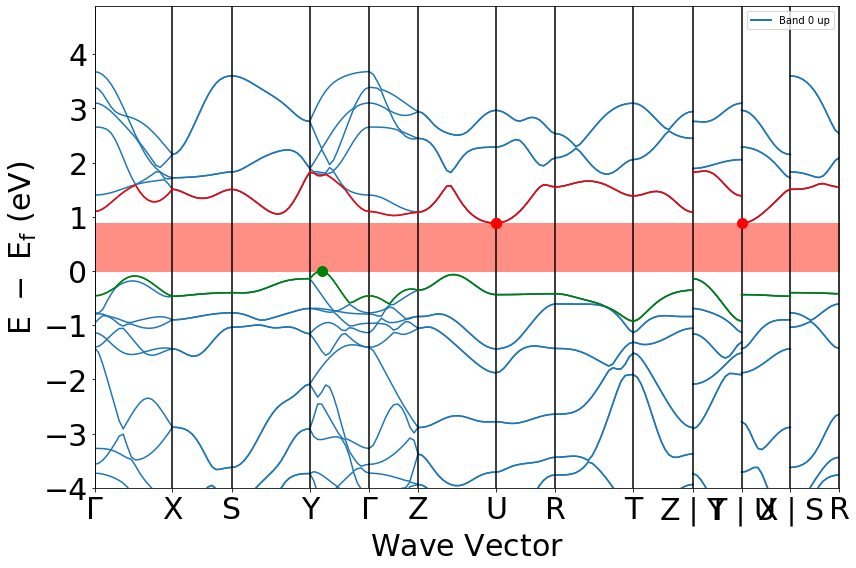

In [8]:
#affichage de la structure de bandes électroniques
plot.get_plot()
plt.fill_between(np.linspace(distance[0],distance[-1],500),0,bandgap.get('energy'),color="#FF8E85")

for i in range(len(distances)):
    plt.plot(distances[i],energy.get('1')[i][25],'g')
    plt.plot(distances[i],energy.get('1')[i][26],'r')

cbms = data.get('cbm')
for i in range(len(cbms)):
	(a,b) = cbms[i]
	plt.plot(a,b,'or',markersize=10)
vbms = data.get('vbm')
for i in range(len(vbms)):
	(a,b) = vbms[i]
	plt.plot(a,b,'og',markersize=10)

# Dispersions maximale et minimale sur la dernière bande de valence et la première bande de conduction

In [9]:
#calcule la pente sur l'intervalle (x,y)
#renvoit un tableau pour un affichage pratique des flèches : 
#    pour chaque intervalle entre 2 kpoints : [pente,x_0,y_0,dx,dy]
def slope(x,y):
	return np.array([abs((y[-1]-y[0])/(x[-1]-x[0])),x[0],y[0],x[-1]-x[0],y[-1]-y[0]])

#calcule la dispersions maximale et minimale de la bande y
#retourne : s=tableau des résultats retournés par slope pour chaque intervalle de kpoints
#           l'indice de la pente maximale dans s
#           l'indice de la pente minimale dans s
def computeDispersions(y):
	slopes = np.zeros((len(distances),5))
	for i in range(len(slopes)):
		slopes[i] = slope(distances[i],energy.get('1')[i][y])
	s = (slopes.T)
	return (s,np.argmax(s[0]),np.argmin(s[0]))

(cbs,maxCb,minCb) = computeDispersions(26)
(vbs,maxVb,minVb) = computeDispersions(25)

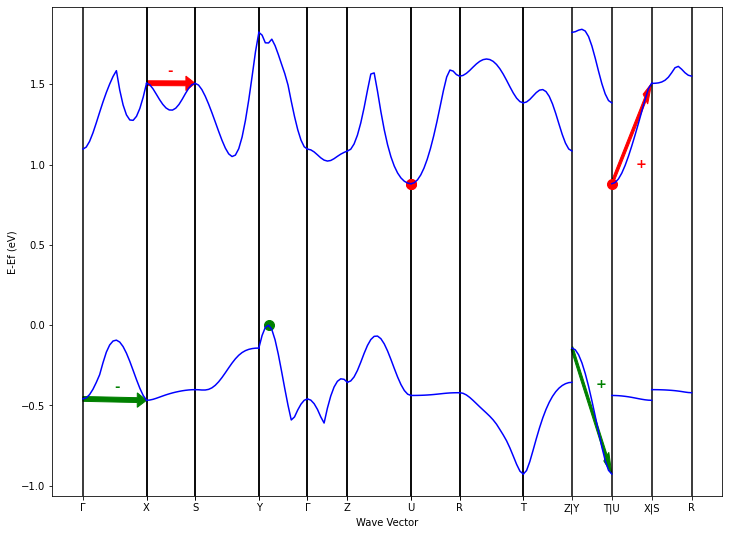

In [10]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
for i in range(len(distance)):
	plt.axvline(distance[i],0,color="black")
    
for i in range(len(vbms)):
	(a,b) = vbms[i]
	plt.plot(a,b,'og',markersize=10)
for i in range(len(cbms)):
	(a,b) = cbms[i]
	plt.plot(a,b,'or',markersize=10)
    
for i in range(len(distances)):
	plt.plot(distances[i],energy.get('1')[i][25],'b')
	plt.plot(distances[i],energy.get('1')[i][26],'b')
    
ax.set_xticks(distance)
ax.set_xticklabels(['\u0393','X',"",'S',"",'Y',"",'\u0393',"",'Z',"",'U',"",'R',"",'T',"",'Z|Y','T|U','X|S','R'])
ax.set_xlabel('Wave Vector')
ax.set_ylabel('E-Ef (eV)')

plt.arrow(cbs[1,maxCb],cbs[2,maxCb],cbs[3,maxCb],cbs[4,maxCb],color='red',width=0.03,length_includes_head=True)
plt.arrow(cbs[1,minCb],cbs[2,minCb],cbs[3,minCb],cbs[4,minCb],color='red',width=0.03,length_includes_head=True)
plt.arrow(vbs[1,maxVb],vbs[2,maxVb],vbs[3,maxVb],vbs[4,maxVb],color='green',width=0.03,length_includes_head=True)
plt.arrow(vbs[1,minVb],vbs[2,minVb],vbs[3,minVb],vbs[4,minVb],color='green',width=0.03,length_includes_head=True)

plt.text(cbs[1,maxCb]+0.35,cbs[2,maxCb]+0.1,"+",fontsize=13,fontweight='bold',color='red')
plt.text(cbs[1,minCb]+0.3,cbs[2,minCb]+0.05,"-",fontsize=13,fontweight='bold',color='red')
plt.text(vbs[1,maxVb]+0.35,vbs[2,maxVb]-0.25,"+",fontsize=13,fontweight='bold',color='green')
plt.text(vbs[1,minVb]+0.45,vbs[2,minVb]+0.05,"-",fontsize=13,fontweight='bold',color='green')

plt.show()

# Détermination de la masse effective au sommet de la dernière bande de valence et à la base de la première bande de conduction suivant une dispersion parabolique


--------------------------  -------------------------------------------------------------------
Parabole d'approximation :  y(k) = -7.619311008466354k² + 41.11376434533528k -55.46225002365103
Dérivée seconde :           -15.238622016932707 eVÅ²
Masse effective :           -4.555082185385014e-31 kg




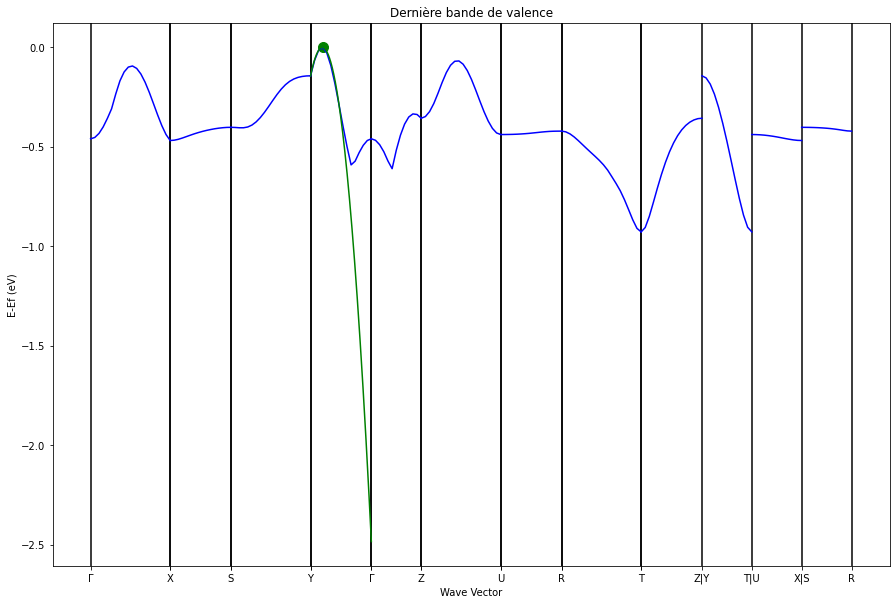

In [11]:
fig,ax = plt.subplots(1,1,figsize=[15,10])
for i in range(len(distance)):
	plt.axvline(distance[i],0,color="black")
for i in range(len(vbms)):
	(a,b) = vbms[i]
	plt.plot(a,b,'og',markersize=10)
for i in range(len(distances)):
	plt.plot(distances[i],energy.get('1')[i][25],'b')
ax.set_xticks(distance)
ax.set_xticklabels(['\u0393','X',"",'S',"",'Y',"",'\u0393',"",'Z',"",'U',"",'R',"",'T',"",'Z|Y','T|U','X|S','R'])
ax.set_xlabel('Wave Vector')
ax.set_ylabel('E-Ef (eV)')
plt.title('Dernière bande de valence')

#calcul de la parabole d'approximation aux alentours du VBM
ks = np.zeros(3)
es = np.zeros(3)
(ks[1],es[1]) = vbms[0]
(ks[0],es[0]) = (distances[3][0],energy.get('1')[3][25][0])
(ks[2],es[2]) = (distances[3][2],energy.get('1')[3][25][2])
a = np.polyfit(ks,es,2)

#affichage des résultats
print(tabulate([["Parabole d'approximation : ","y(k) = "+str(a[0])+"k\u00b2 + "+str(a[1])+"k "+str(a[2])],
	            ["Dérivée seconde : ",str(2*a[0])+" eV\u212b\u00b2"],
                ["Masse effective : ",str(hbar2/(2*a[0]*electronvolt*(angstrom)**2))+" kg"]],
	            headers=["",""]))
print("\n")
x = np.linspace(distances[3][0],distances[3][-1],1000)
plt.plot(x,np.polyval(a,x),'g')
plt.show()


--------------------------  --------------------------------------------------------------------
Parabole d'approximation :  y(k) = 2.7084205373110883k² -25.720203642165234k +61.940816676573796
Dérivée seconde :           5.416841074622177 eVÅ²
Masse effective :           1.2814327524642686e-30 kg




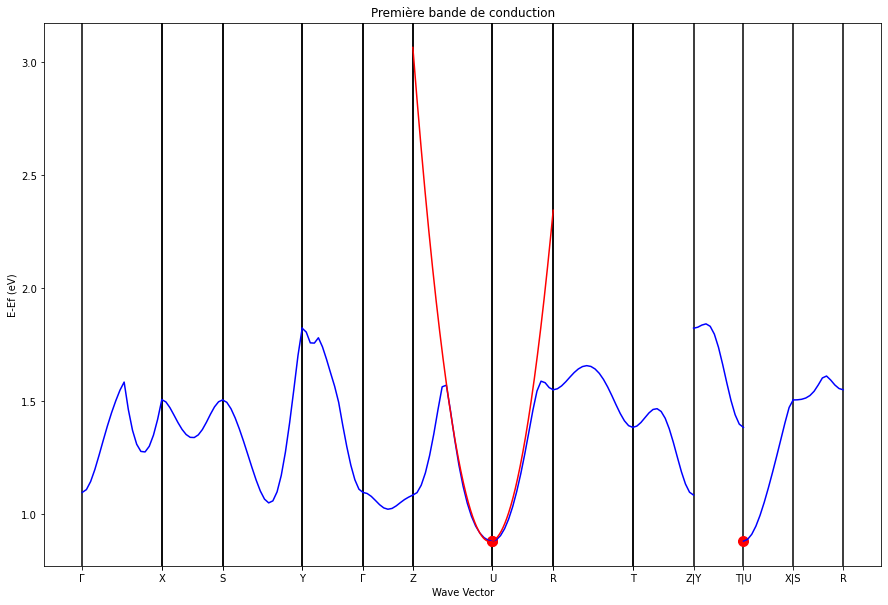

In [72]:
#plot de la première bande de conduction et du CBM
fig,ax = plt.subplots(1,1,figsize=[15,10])
for i in range(len(distance)):
	plt.axvline(distance[i],0,color="black")
for i in range(len(cbms)):
	(a,b) = cbms[i]
	plt.plot(a,b,'or',markersize=10)
for i in range(len(distances)):
	plt.plot(distances[i],energy.get('1')[i][26],'b')
ax.set_xticks(distance)
ax.set_xticklabels(['\u0393','X',"",'S',"",'Y',"",'\u0393',"",'Z',"",'U',"",'R',"",'T',"",'Z|Y','T|U','X|S','R'])
ax.set_xlabel('Wave Vector')
ax.set_ylabel('E-Ef (eV)')
plt.title('Première bande de conduction')

#calcul de la parabole d'approximation aux alentours du VBM
ks2 = np.zeros(3)
es2 = np.zeros(3)
(ks2[1],es2[1]) = cbms[1]
(ks2[0],es2[0]) = (distances[5][-4],energy.get('1')[5][26][-4])
(ks2[2],es2[2]) = ((distances[6][2]+distances[6][1])/2,energy.get('1')[6][26][2])
a2 = np.polyfit(ks2,es2,2)

#affichage des résultats
print(tabulate([["Parabole d'approximation : ","y(k) = "+str(a2[0])+"k\u00b2 "+str(a2[1])+"k +" +str(a2[2])],
	            ["Dérivée seconde : ",str(2*a2[0])+" eV\u212b\u00b2"],
                ["Masse effective : ",str(hbar2/(2*a2[0]*electronvolt*(angstrom)**2))+" kg"]],
	           headers=["",""]))
print("\n")
x2 = np.linspace(distances[5][0],distances[6][-1],1000)
plt.plot(x2,np.polyval(a2,x2),'r')
plt.show()